In [1]:
# libraries to import
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

# Stochastic Linear Bandits

# Strategy 1: UCB Algorithm

The difference here is that instead of having confidence intervals, we have confidence ellipsoids.

The goal of the algorithm is to optimize the selection of actions (arms) in order to maximize the cumulative reward received over a series of rounds.

The key idea behind the algorithm is to model the relationship between the observed rewards and the features of each arm using linear regression, and then use the estimated regression coefficients to make informed decisions about which arm to select in each round.

### Steps of the algorithm



In [64]:
# --------- Start of the algorithm LinUCB -----------
def linUCB_algorithm(n_arms, n_features, item_features, true_theta, n_rounds, noise, lambda_param):
    
    # Initialize feature matrix.
    # V_t[i, j] represents the sum of the product of the ith and jth feature components across all observed data points.
    # V_t[i, i] represents the sum of the squared ith feature components.
    # Initializing V_0 to lambda * Identity matrix makes it invertible.
    V_t = lambda_param * np.eye(n_features)

    # Initialize label vector.
    # Represents the sum of the product of the observed rewards with each feature component across all observed data points.
    sum_A_s_X_s = np.zeros(n_features)
    
    # Initialize theta_hat matrix, where each column represents the estimate of the true_theta vector at each round.
    theta_hat = np.zeros((n_features, n_rounds + 1))
    theta_hat[:, 0] = np.random.uniform(low=-1, high=1, size=(n_features, 1)).reshape((n_features,))

    # Initialize arrays to store actions, rewards and regrets.
    actions = np.zeros(n_rounds + 1, dtype=int)
    rewards = np.zeros(n_rounds + 1)
    regrets = np.zeros(n_rounds + 1)

    for t in range(1, n_rounds + 1):
        
        # Compute beta parameter for this round using the given formula.
        beta_param_t = 1.0 # should increase logarithmically
        
        # Choose the best action based on the last theta_hat.
        max_value = -np.Inf
        max_index = -1
        for i in range(n_arms):
            # Compute the UCB for each arm using the given formula.
            estimated_value = theta_hat[:, t-1].T @ item_features[:, i]
            penalty_value = np.sqrt(beta_param_t) * np.sqrt(item_features[:, i].T @ (np.linalg.inv(V_t) @ item_features[:, i]))
            value = estimated_value + penalty_value
            if value >= max_value:
                max_value = value
                max_index = i

        # Update the best action to take for this round.
        actions[t] = max_index
        
        # Observe the reward of the chosen action and add noise.
        expected_reward = true_theta.T @ item_features[:, actions[t]]
        rewards[t] = expected_reward + np.random.normal(scale=noise) # this might be the reason why we get negative regret

        # Regret calculus - to be separated from this method --------
        # Compute the regret for this round.
        optimal_reward = np.max(item_features.T @ true_theta) # todo put this outside the for loop
        # print("optimal reward possible : " + str(optimal_reward) + " with arm " + str(np.argmax(item_features.T @ true_theta)))
        regret = optimal_reward - expected_reward
        # print("regret : " + str(regret))
        regrets[t] = regrets[t - 1] + regret
        
        # Update the feature matrix V_t by adding the outer product of the chosen action's feature vector with itself.
        V_t += np.outer(item_features[:, actions[t]], item_features[:, actions[t]])

        # Compute the inverse of the updated feature matrix V_t.
        V_t_inv = np.linalg.inv(V_t)

        # Update the label vector sum_A_s_X_s by adding the outer product of the chosen action's feature vector with the observed reward.
        sum_A_s_X_s += item_features[:, actions[t]] * rewards[t]
        
        # Compute the new estimate of the true_theta vector using the updated feature matrix and label vector.
        # This estimate represents the center of the ellipsoid in the feature space.
        theta_hat[:, t] = V_t_inv @ sum_A_s_X_s
        
    return actions, rewards, regrets, theta_hat[:, n_rounds]


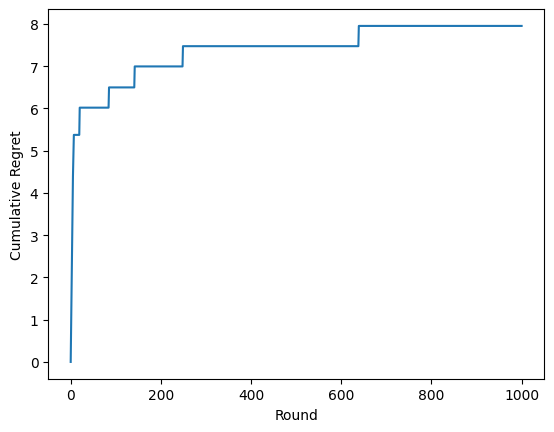

The true theta is equal to : [[-0.00704452]
 [ 0.00724613]
 [ 0.72732266]
 [ 0.27209262]
 [-0.44704592]]
The theta hat we find at the end is equal to :  [ 0.03938744 -0.10076935  0.84534759  0.30067731 -0.42810604]


In [65]:
# Setting up parameters for the runs
n_arms = 20
n_features = 5
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))

n_rounds = 1000
noise = 0.1 # 0.1 -> can lead to negative regret since the reward could be the optimal + some noise
lambda_param = 0.5

# Running the algorithm
actions, rewards, regrets, theta_hat = linUCB_algorithm(n_arms, n_features, item_features, true_theta, n_rounds, noise, lambda_param)

# Plotting the regret
plt.plot(regrets)
plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.show()

# Printing the true theta a
print("The true theta is equal to : " + str(true_theta))
print("The theta hat we find at the end is equal to : ", str(theta_hat))

In [11]:
print(true_theta)
print(item_features)

[[-0.86781442]
 [-0.05285704]
 [ 0.96474989]
 [-0.56917683]
 [ 0.6991424 ]]
[[ 0.70228401 -0.72917991 -0.9483827  -0.51564549 -0.92298944  0.77208918
   0.74425408  0.69933812 -0.61581112 -0.82854909  0.05013887  0.27373284
  -0.72547333  0.55233037  0.07204522 -0.53578193  0.74120235  0.27049865
  -0.77261506  0.42876097]
 [ 0.09084605  0.97539222 -0.43891874 -0.16718894  0.04738833 -0.7995073
  -0.55535811  0.44850417  0.76603576  0.57030719  0.74127144 -0.34431605
  -0.47115412  0.78637504 -0.73108753  0.20867553  0.56345788  0.59458064
  -0.11231201 -0.02170361]
 [-0.57605031  0.66094118 -0.30921841  0.88606714 -0.57332963 -0.27602068
  -0.81166827 -0.56394916 -0.28108235 -0.6885897   0.20230342 -0.52861209
   0.80411333  0.34420484 -0.9667643   0.79291866  0.61094027 -0.19570448
  -0.45409473  0.23146287]
 [-0.65618179  0.34746428  0.06155052 -0.26575155 -0.67574622  0.55256431
   0.15776922 -0.63226733  0.23655987  0.12759724 -0.34238922 -0.30789612
  -0.32005747  0.98095672 -0.5

In [9]:
# I will wrap everything in a class when I get a working algorithm

# class UCB_linear_bandit:
#     def __init__(self, true_theta, item_features, num_rounds, noise):
#         self.true_theta = true_theta
#         self.item_features = item_features
#         self.num_rounds = num_rounds
#         self.noise = noise
        
#         self.actions = np.zeros(num_rounds)
#         self.regrets = np.zeros(num_rounds)

In [83]:
class LinUCB:
    def __init__(self, n_arms, n_features, item_features, n_rounds, lambda_param):
        self.n_arms = n_arms
        self.n_features = n_features
        self.item_features = item_features
        self.n_rounds = n_rounds
        self.lambda_param = lambda_param

        # Initializing variables
        self.V_t = lambda_param * np.eye(n_features)
        self.sum_A_s_X_s = np.zeros(n_features)
        self.theta_hat = np.zeros((n_features, n_rounds + 1))
        self.theta_hat[:, 0] = np.random.uniform(low=-1, high=1, size=(n_features, 1)).reshape((n_features,))

        self.beta_param_t = 1.0
        self.actions = np.zeros(n_rounds + 1, dtype=int)
        self.rewards = np.zeros(n_rounds + 1)

    # Choose the best action based on the last theta_hat
    def choose_action(self, curr_round):
        max_value = -np.Inf
        max_index = -1
        for i in range(self.n_arms):
            # Compute the UCB for each arm using the given formula
            estimated_value = self.theta_hat[:, curr_round-1].T @ self.item_features[:, i]
            penalty_value = np.sqrt(self.beta_param_t) * np.sqrt(self.item_features[:, i].T @ (np.linalg.inv(self.V_t) @ self.item_features[:, i]))
            value = estimated_value + penalty_value
            if value >= max_value:
                max_value = value
                max_index = i

        # Storing it
        self.actions[curr_round] = max_index
        return max_index

    # Updating variables after receiving the reward from an action
    def update(self, curr_round, reward):
        self.rewards[curr_round] = reward

        # Update the feature matrix V_t by adding the outer product of the chosen action's feature vector with itself.
        self.V_t += np.outer(item_features[:, actions[curr_round]], item_features[:, actions[curr_round]])

        # Compute the inverse of the updated feature matrix V_t.
        V_t_inv = np.linalg.inv(self.V_t)

        # Update the label vector sum_A_s_X_s by adding the outer product of the chosen action's feature vector with the observed reward.
        self.sum_A_s_X_s += item_features[:, actions[curr_round]] * rewards[curr_round]

        # Compute the new estimate of the true_theta vector using the updated feature matrix and label vector.
        # This estimate represents the center of the ellipsoid in the feature space.
        theta_hat[:, curr_round] = V_t_inv @ self.sum_A_s_X_s

class EnvironmentLinUCB:
    def __init__(self, n_arms, n_features, item_features, n_rounds, true_theta, noise):
        self.n_arms = n_arms
        self.n_features = n_features
        self.item_features = item_features
        self.n_rounds = n_rounds
        self.true_theta = true_theta
        self.noise = noise

        # Initializing variables
        self.optimal_reward = np.max(item_features.T @ true_theta)
        self.rewards = np.zeros(n_rounds + 1) # rewards with noise
        self.regrets = np.zeros(n_rounds + 1)

    # Observe the reward of the chosen action and add noise.
    def observe_reward(self, action, curr_round):
        expected_reward = true_theta.T @ item_features[:, action]
        self.rewards[curr_round] = expected_reward + np.random.normal(scale=noise) # this might be the reason why we get negative regret
        return self.rewards[curr_round]

    def calculate_regret(self, curr_round, expected_reward):
        # Compute the regret for this round.
        regret = self.optimal_reward - expected_reward

        print(self.regrets[curr_round])

        # self.regrets[curr_round] = self.regrets[curr_round - 1] + regret

    def get_regrets(self):
        return self.regrets



In [86]:
n_arms = 5
n_features = 10
item_features = np.random.randn(n_features, n_arms)
true_theta = np.random.uniform(low=-1, high=1, size=(n_features,))
n_rounds = 1000
noise = 0.1
lambda_param = 0.1

def RunLinUCB(n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param):

    # Initializing the LinUCB class
    linucb = LinUCB(n_arms, n_features, item_features, n_rounds, lambda_param)

    # Initializing the environment
    environment = EnvironmentLinUCB(n_arms, n_features, item_features, n_rounds, true_theta, noise)

    for t in range(1, n_rounds + 1):

        # Picking up the best action based on theta_hat
        arm_chosen = linucb.choose_action(t)

        # Reward received based on the action taken
        reward = environment.observe_reward(arm_chosen, t)

        # Compute regret
        environment.calculate_regret(round, reward)

        # Update algorithm values after receiving reward
        linucb.update(t, reward)

    regrets = environment.get_regrets()

    # Plot the results
    plt.plot(regrets)
    plt.xlabel('Round')
    plt.ylabel('Cumulative Regret')
    plt.show()

RunLinUCB(n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices